In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import abstract_gradient_training as agt
import sklearn
import copy
import gurobipy as gp
from gurobipy import GRB
import json
from tqdm import tqdm
import random
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import scienceplots

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Plot Mean of R Values

In [7]:
ensemble_size = 20
seed = 0
total_dataset_size = 50000
train_dataset_size_per_member = total_dataset_size // ensemble_size
batch_size = train_dataset_size_per_member

# train_dataset_size_per_member = 10000
# total_dataset_size = train_dataset_size_per_member * ensemble_size
# batch_size = train_dataset_size_per_member
test_size = 1000
# n_batches = 3  # number of batches per epoch
n_epochs = 4  # number of epochs

torch.manual_seed(seed)
# load the dataset
x, y = sklearn.datasets.make_moons(noise=0.1, n_samples=total_dataset_size + test_size, random_state=seed)
# to make it easier to train, we'll space the moons out a bit and add some polynomial features
x[y==0, 1] += 0.2
x = np.hstack((x, x**2, (x[:, 0] * x[:, 1])[:, None], x**3))
# perform a test-train split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=test_size, random_state=seed
)   

# convert into pytorch dataloaders
x_train, y_train = torch.from_numpy(x_train).float().to(device), torch.from_numpy(y_train).to(device)
x_test, y_test = torch.from_numpy(x_test).float().to(device), torch.from_numpy(y_test).to(device)
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataset_test = torch.utils.data.TensorDataset(x_test, y_test)
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=250, shuffle=False)

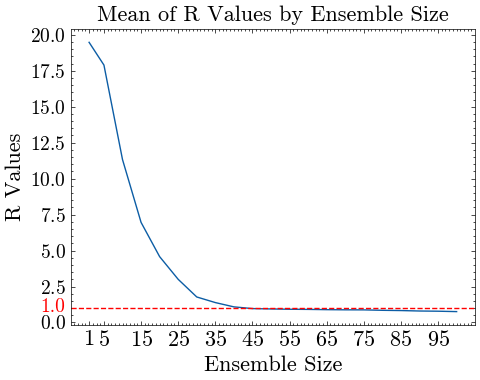

In [ ]:
## Plot mean of R values (fixed total dataset size)
plt.style.use(["science", "no-latex"])
N=20
s=5
data = []
dir_name = f".graph_results/ens_run_50k_total"
# dir_name = f".graph_results"
sizes = [1] + list(range(5, 101, 5))  # Ensemble sizes from 1 to 100 in steps of 5
for ensemble_size in sizes:
    scores = torch.load(f"{dir_name}/scores_{N}_{ensemble_size}_{s}.pth")
    # print(scores.shape)
    preds = scores.argmax(dim=2).to(device)
    # print(preds.shape)
    y_expanded = y_test.unsqueeze(1).expand(-1, preds.size(1)).to(device)
    correct = (preds == y_expanded).to(device)
    bs = torch.load(f"{dir_name}/moons_agt_bs_{N}_{ensemble_size}_{s}.pth")
    # bs = bs.reshape(-1)
    
    # filter values greater than N
    bs = bs[correct.T.cpu()]

    data.append(torch.mean(bs).cpu() - 1)

# Plot with default (shows outliers as dots)
plt.figure(figsize=(5, 4))
# sns.boxplot(x="Ensemble Size", y="R values", data=data, palette="Set2")
plt.plot(sizes, data)
plt.axhline(y=1, color='r', linestyle='--', label='R = 0')
plt.title('Mean of R Values by Ensemble Size', fontsize=16)
plt.xlabel('Ensemble Size', fontsize=16)
plt.ylabel('R Values', fontsize=16)
plt.xticks([1] + list(range(5, 101, 10)), fontsize=16)
plt.yticks(fontsize=14)
# Add text at y=1 to indicate R = 1 small tet
plt.gca().text(-0.075, 0.045, '1.0', transform=plt.gca().transAxes, color='red', fontsize=14)
plt.tight_layout()
# plt.savefig(f"../figures/boxplot_moons_ensemble_size_N={N}_{s}_mean_line.pdf", bbox_inches='tight')
plt.show()

In [10]:
ensemble_size = 20
seed = 0
# total_dataset_size = 50000
# train_dataset_size_per_member = total_dataset_size // ensemble_size
# batch_size = train_dataset_size_per_member

train_dataset_size_per_member = 10000
total_dataset_size = train_dataset_size_per_member * ensemble_size
batch_size = train_dataset_size_per_member
test_size = 1000
# n_batches = 3  # number of batches per epoch
n_epochs = 4  # number of epochs

torch.manual_seed(seed)
# load the dataset
x, y = sklearn.datasets.make_moons(noise=0.1, n_samples=total_dataset_size + test_size, random_state=seed)
# to make it easier to train, we'll space the moons out a bit and add some polynomial features
x[y==0, 1] += 0.2
x = np.hstack((x, x**2, (x[:, 0] * x[:, 1])[:, None], x**3))
# perform a test-train split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=test_size, random_state=seed
)   

# convert into pytorch dataloaders
x_train, y_train = torch.from_numpy(x_train).float().to(device), torch.from_numpy(y_train).to(device)
x_test, y_test = torch.from_numpy(x_test).float().to(device), torch.from_numpy(y_test).to(device)
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataset_test = torch.utils.data.TensorDataset(x_test, y_test)
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=250, shuffle=False)

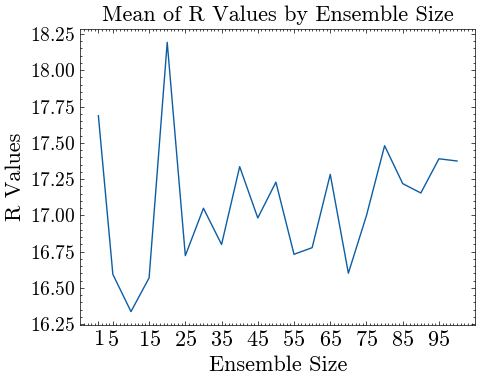

In [11]:
## Plot mean of R values (fixed dataset size per member)
plt.style.use(["science", "no-latex"])
N=20
s=5
data = []
dir_name = f".graph_results/ens_run_fixed"
# dir_name = f".graph_results"
sizes = [1] + list(range(5, 101, 5))  # Ensemble sizes from 1 to 100 in steps of 5
for ensemble_size in sizes:
    scores = torch.load(f"{dir_name}/scores_{N}_{ensemble_size}_{s}_fixed.pth")
    # print(scores.shape)
    preds = scores.argmax(dim=2).to(device)
    # print(preds.shape)
    y_expanded = y_test.unsqueeze(1).expand(-1, preds.size(1)).to(device)
    correct = (preds == y_expanded).to(device)
    bs = torch.load(f"{dir_name}/moons_agt_bs_{N}_{ensemble_size}_{s}_fixed.pth")
    # bs = bs.reshape(-1)
    
    # filter values greater than N
    bs = bs[correct.T.cpu()]

    data.append(torch.mean(bs).cpu() - 1)

# Plot with default (shows outliers as dots)
plt.figure(figsize=(5, 4))
# sns.boxplot(x="Ensemble Size", y="R values", data=data, palette="Set2")
plt.plot(sizes, data)
# plt.axhline(y=1, color='r', linestyle='--', label='R = 0')
plt.title('Mean of R Values by Ensemble Size', fontsize=16)
plt.xlabel('Ensemble Size', fontsize=16)
plt.ylabel('R Values', fontsize=16)
plt.xticks([1] + list(range(5, 101, 10)), fontsize=16)
plt.yticks(fontsize=14)
# Add text at y=1 to indicate R = 1 small tet
# plt.gca().text(-0.075, 0.045, '1.0', transform=plt.gca().transAxes, color='red', fontsize=14)
plt.tight_layout()
plt.savefig(f"../figures/boxplot_moons_ensemble_size_N={N}_{s}_mean_line_fixed_1.pdf", bbox_inches='tight')
plt.show()

### Box plot of R values

10000 10 1000
50000 50 1000
100000 100 1000


/tmp/ipykernel_2002919/2201170826.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Ensemble Size", y="R values", data=data, palette="Set2")


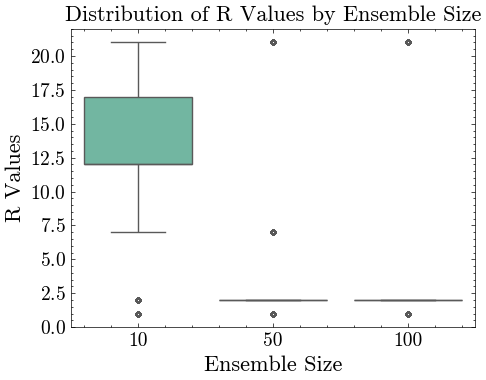

In [ ]:
## Generate box plot for R value (fixed total dataset size)
plt.style.use(["science", "no-latex", "scatter"])
N=20
s=5
data = []
sizes = [10, 50, 100]
dir_name = f".graph_results/ens_run_50k_total"
for ensemble_size in sizes:
    bs = torch.load(f"{dir_name}/moons_agt_bs_{N}_{ensemble_size}_{s}.pth")
    data.append(bs.cpu().numpy().flatten())
    print(bs.shape[0] * bs.shape[1], bs.shape[0], bs.shape[1])


data = pd.DataFrame({
    "Ensemble Size": [sizes[0]] * len(data[0]) + [sizes[1]] * len(data[1]) + [sizes[2]] * len(data[2]),
    "R values": np.concatenate(data)
})

# Plot with default (shows outliers as dots)
plt.figure(figsize=(5, 4))
sns.boxplot(x="Ensemble Size", y="R values", data=data, palette="Set2")
plt.title('Distribution of R Values by Ensemble Size', fontsize=16)
plt.xlabel('Ensemble Size', fontsize=16)
plt.ylabel('R Values', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig(f"../figures/boxplot_moons_ensemble_size_N={N}_{s}_fixed.pdf", bbox_inches='tight')
plt.show()

10000 10 1000
50000 50 1000
100000 100 1000


/tmp/ipykernel_2071444/4246745886.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Ensemble Size", y="R values", data=data, palette="Set2")


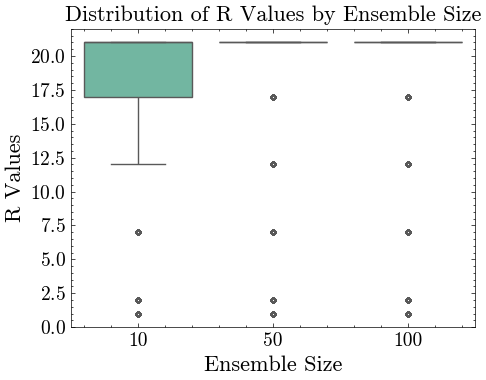

In [7]:
## Generate box plot for R value (fixed dataset size per member)
plt.style.use(["science", "no-latex", "scatter"])
N=20
s=5
data = []
sizes = [10, 50, 100]
dir_name = f".graph_results/ens_run_fixed"
for ensemble_size in sizes:
    bs = torch.load(f"{dir_name}/moons_agt_bs_{N}_{ensemble_size}_{s}_fixed.pth")
    data.append(bs.cpu().numpy().flatten())
    print(bs.shape[0] * bs.shape[1], bs.shape[0], bs.shape[1])


data = pd.DataFrame({
    "Ensemble Size": [sizes[0]] * len(data[0]) + [sizes[1]] * len(data[1]) + [sizes[2]] * len(data[2]),
    "R values": np.concatenate(data)
})

# Plot with default (shows outliers as dots)
plt.figure(figsize=(5, 4))
sns.boxplot(x="Ensemble Size", y="R values", data=data, palette="Set2")
plt.title('Distribution of R Values by Ensemble Size', fontsize=16)
plt.xlabel('Ensemble Size', fontsize=16)
plt.ylabel('R Values', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig(f"../figures/boxplot_moons_ensemble_size_N={N}_{s}_fixed.pdf", bbox_inches='tight')
plt.show()

### Plot graphs of nominal accuracy and certified accuracy vs ensemble size

[0.9180000424385071, 0.9190000295639038, 0.9020000696182251, 0.906000018119812, 0.9100000262260437, 0.906000018119812, 0.9080000519752502, 0.8960000276565552, 0.9040000438690186, 0.9040000438690186, 0.9080000519752502, 0.9050000309944153, 0.909000039100647, 0.9070000648498535, 0.9040000438690186, 0.9070000648498535, 0.9050000309944153, 0.9070000648498535, 0.9070000648498535, 0.906000018119812, 0.9070000648498535] [0.8799999999999999, 0.851, 0.8139999999999998, 0.7909999999999999, 0.7439999999999998, 0.8639999999999999, 0.8639999999999999, 0.8619999999999999, 0.859, 0.8659999999999999, 0.8679999999999999, 0.879, 0.875, 0.879, 0.8819999999999999, 0.8819999999999999, 0.883, 0.8879999999999999, 0.885, 0.893, 0.887]


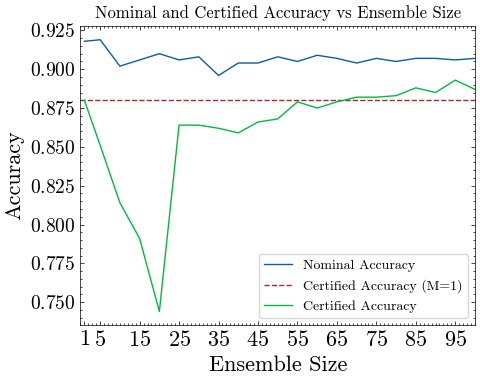

In [ ]:
# Plot a line graph of the results for fixed total dataset size
plt.style.use(["science", "no-latex"])
N=20
s=5
xs = [1] + list(range(5, 101, 5))
nom_accs_total = []
worst_accs_total = []
dir = f".graph_results/ens_run_50k_total"
nom_accs = []
worst_accs = []
for ensemble_size in xs:
    na = torch.load(f"{dir}/ensemble_preds_agt_dpa_{N}_{ensemble_size}_{s}.pth")["nom_acc"]
    wa = torch.load(f"{dir}/moons_agt_p_k={N}_{ensemble_size}_{s}.pth")["cert_acc"]
    nom_accs.append(na)
    worst_accs.append(wa)
print(nom_accs, worst_accs)

plt.figure(figsize=(5, 4))
plt.plot(xs, nom_accs, label='Nominal Accuracy')
# plt.plot(xs, pointwise_accs, label='Pointwise Accuracy', linestyle='--')
plt.axhline(worst_accs[0], linestyle='--', color='brown', label='Certified Accuracy (M=1)')
plt.plot(xs, worst_accs, label='Certified Accuracy')
plt.title('Nominal and Certified Accuracy vs Ensemble Size')
plt.xlabel('Ensemble Size', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks([1] + list(range(5, 101, 10)), fontsize=16)
plt.yticks(fontsize=14)
plt.xlim(0, 100)

plt.legend(
    frameon=True,              # Show legend box
)
plt.tight_layout()
# plt.savefig(f'../figures/moons_ens_ft_{N}_{s}_fixed_line.pdf')
plt.show()

[0.9330000281333923, 0.9190000295639038, 0.9350000023841858, 0.9229999780654907, 0.9359999895095825, 0.9190000295639038, 0.9229999780654907, 0.9210000038146973, 0.9269999861717224, 0.9330000281333923, 0.9200000166893005, 0.9309999942779541, 0.9039999842643738, 0.9010000228881836, 0.9100000262260437, 0.9330000281333923, 0.9200000166893005, 0.9129999876022339, 0.9150000214576721, 0.9319999814033508, 0.9169999957084656] [0.8139999999999998, 0.851, 0.8839999999999999, 0.8879999999999999, 0.907, 0.8959999999999999, 0.8959999999999999, 0.9039999999999999, 0.905, 0.9219999999999999, 0.9099999999999999, 0.915, 0.8939999999999999, 0.8919999999999999, 0.9019999999999999, 0.9279999999999999, 0.9139999999999999, 0.9079999999999999, 0.905, 0.9299999999999999, 0.9119999999999999]


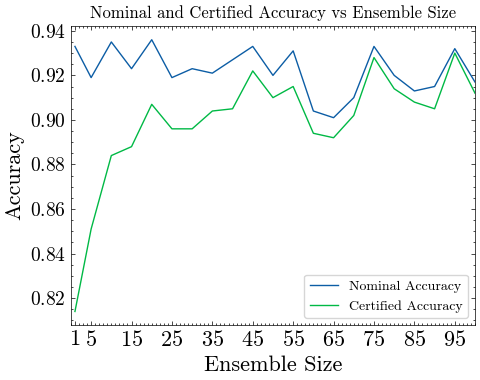

In [5]:
# Plot a line graph of the results for fixed dataset size per member
plt.style.use(["science", "no-latex"])
N=20
s=5
xs = [1] + list(range(5, 101, 5))
nom_accs_total = []
worst_accs_total = []
dir = f".graph_results/ens_run_fixed"
nom_accs = []
worst_accs = []
for ensemble_size in xs:
    na = torch.load(f"{dir}/ensemble_preds_agt_dpa_{N}_{ensemble_size}_{s}_fixed.pth")["nom_acc"]
    wa = torch.load(f"{dir}/moons_agt_p_k={N}_{ensemble_size}_{s}_fixed.pth")["cert_acc"]
    nom_accs.append(na)
    worst_accs.append(wa)
print(nom_accs, worst_accs)

plt.figure(figsize=(5, 4))
plt.plot(xs, nom_accs, label='Nominal Accuracy')
# plt.plot(xs, pointwise_accs, label='Pointwise Accuracy', linestyle='--')
# plt.axhline(worst_accs[0], linestyle='--', color='brown', label='Certified Accuracy (M=1)')
plt.plot(xs, worst_accs, label='Certified Accuracy')
plt.title('Nominal and Certified Accuracy vs Ensemble Size')
plt.xlabel('Ensemble Size', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks([1] + list(range(5, 101, 10)), fontsize=16)
plt.yticks(fontsize=14)
plt.xlim(0, 100)

plt.legend(
    frameon=True,              # Show legend box
)
plt.tight_layout()
# plt.savefig(f'../figures/moons_ens_ft_{N}_{s}_fixed_line.pdf')
plt.show()